# Verify and Clean

#### Evan Yathon
#### 

This notebook is intended to be run with papermill from the project root.

The purpose of this notebook is to take a first look at the data, clean it where necessary and ensure that all reviews in the original given dataset (`data/given_4U_reviews.txt`) all exist in my newly scraped dataset.

Usage:

`papermill src/ipynbs/verify_and_clean.ipynb src/verify_and_clean_ran.ipynb -p load_path data/scraped_gw_reviews.csv -p save_path data/cleaned_gw_reviews.csv -p old_data_path data/given_4U_reviews.txt`

In [1]:
#parameters section for Papermill

load_path = "../../data/scraped_gw_reviews.csv"
save_path = "../../data/cleaned_gw_reviews.csv"
old_data_path = "../../data/given_4U_reviews.txt"

In [2]:
# Parameters
load_path = "data/scraped_gw_reviews.csv"
save_path = "data/cleaned_gw_reviews.csv"
old_data_path = "data/given_4U_reviews.txt"


In [3]:
# loading packages

# utils
import pandas as pd
import time
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# ensure the dates are parsed correctly with parse_dates argument
reviews = pd.read_csv(load_path, parse_dates = ["date_of_review", "date_flown"])

In [5]:
reviews.head(5)

,title,review_value,n_user_reviews,reviewer_name,reviewer_country,date_of_review,review_text,aircraft,traveller_type,seat_type,route,date_flown,seat_comfort_rating,cabin_staff_service_rating,food_and_beverages_rating,inflight_entertainment_rating,ground_service_rating,value_for_money_rating,recommendation
0,"""Seat was fine with enough legroom""",7.0,9 reviews,Sander van Kan,\n\n9 reviews\n\n\n\nSander van Kan (Netherlan...,2019-07-01,✅ Trip Verified | Dusseldorf to Berlin. Eurowi...,A319,Couple Leisure,Economy Class,Dusseldorf to Berlin,2019-06-01,4.0,3.0,NaN,1.0,3.0,5.0,yes
1,"""crew were smiling and good""",6.0,9 reviews,Sander van Kan,\n\n9 reviews\n\n\n\nSander van Kan (Netherlan...,2019-07-01,✅ Trip Verified | Berlin to Dusseldorf. Eurowi...,A319,Couple Leisure,Economy Class,Berlin to Dusseldorf,2019-06-01,3.0,3.0,NaN,1.0,3.0,5.0,yes
2,"""only two agents available""",1.0,6 reviews,Andrew Maynard,\n\n6 reviews\n\n\n\nAndrew Maynard (United K...,2017-01-04,Check in process at Cologne very poor. Flight ...,NaN,Couple Leisure,Economy Class,CGN to MAN,2017-01-01,2.0,2.0,NaN,NaN,1.0,2.0,no
3,"""good flight and friendly staff""",7.0,1 reviews,T Steen,\n\n1 reviews\n\n\n\nT Steen (Netherlands) 13t...,2016-09-13,✅ Verified Review | Amsterdam to Stuttgart. G...,NaN,Business,Economy Class,AMS to STR,2016-09-01,5.0,5.0,1.0,NaN,5.0,5.0,yes
4,"""never been treated as badly""",1.0,NaN,Karen Kirner,\n\nKaren Kirner (Austria) 16th August 2016,2016-08-16,✅ Verified Review | I have been a frequent tr...,NaN,Business,Economy Class,DUS to VIE,2016-08-01,1.0,1.0,NaN,NaN,3.0,1.0,no


In [6]:
# check what column types we are working with
reviews.dtypes

title                                    object
review_value                            float64
n_user_reviews                           object
reviewer_name                            object
reviewer_country                         object
date_of_review                   datetime64[ns]
review_text                              object
aircraft                                 object
traveller_type                           object
seat_type                                object
route                                    object
date_flown                       datetime64[ns]
seat_comfort_rating                     float64
cabin_staff_service_rating              float64
food_and_beverages_rating               float64
inflight_entertainment_rating           float64
ground_service_rating                   float64
value_for_money_rating                  float64
recommendation                           object
dtype: object

In [7]:
# check to see how many missing values there are for each column
print("Percentage of missing values for each column: \n")
(reviews.isna().sum()/reviews.shape[0])*100

Percentage of missing values for each column: 



title                             0.000000
review_value                      9.589041
n_user_reviews                   89.726027
reviewer_name                     0.000000
reviewer_country                  0.000000
date_of_review                    0.000000
review_text                       0.000000
aircraft                         89.726027
traveller_type                   78.767123
seat_type                        10.273973
route                            78.767123
date_flown                       78.767123
seat_comfort_rating              32.876712
cabin_staff_service_rating       32.876712
food_and_beverages_rating        37.671233
inflight_entertainment_rating    47.945205
ground_service_rating            78.767123
value_for_money_rating            9.589041
recommendation                    0.000000
dtype: float64

It seems that the reviews are missing the majority of `n_user_reviews`, `aircraft`, `traveller_type`, `route`, `date_flown`, and `ground_service_rating`.

Trying to infer things from these columns will likely be not very useful as we only have 146 samples to use.  

#### Verifying that all reviews are in original dataset

In [8]:
# load the original dataset

f = open(old_data_path)
orig_reviews = f.read()
f.close()

In [9]:
# check to make sure that all our extracted reviews are in the original dataset
#
# note that the last review in the given reviews was from 16th October 2015, 
# so there will be some extra reviews
#
# print the date and title of the review if it is not found in the original reviews

for count, review in enumerate(reviews["review_text"]):
    if review not in orig_reviews:
        print(reviews["date_of_review"][count]," : ", reviews["title"][count],"\n")

2019-07-01 00:00:00  :  "Seat was fine with enough legroom" 

2019-07-01 00:00:00  :  "crew were smiling and good" 

2017-01-04 00:00:00  :  "only two agents available" 

2016-09-13 00:00:00  :  "good flight and friendly staff" 

2016-08-16 00:00:00  :  "never been treated as badly" 

2016-05-11 00:00:00  :  "very cramped" 

2016-04-11 00:00:00  :  "staff were friendly" 

2016-02-08 00:00:00  :  PLEASE REFER TO EUROWINGS 

2016-01-23 00:00:00  :  "great value for money" 

2016-01-21 00:00:00  :  "pay very little money" 

2015-12-22 00:00:00  :  "friendly and professional" 

2015-12-07 00:00:00  :  "little choice of airline" 

2015-11-16 00:00:00  :  "were very satisfied" 

2015-11-03 00:00:00  :  "no info or staff" 

2015-10-27 00:00:00  :  "cabin crew were very friendly" 

2015-10-21 00:00:00  :  "professional cabin crew" 

2015-10-21 00:00:00  :  "friendly cabin staff" 

2015-10-15 00:00:00  :  "impressed with Germanwings" 

2015-09-14 00:00:00  :  "I don't get why Germanwings is alw

Most of these reviews are after 16th October 2015, so we know that it is mostly good.  But there are 7 reviews at the bottom that should be showing up as in the scraped dataset.  Let's look at the `2015-09-09 00:00:00  :  "staff friendly - food terrible"` entry.

In [10]:
# the original review copied from the given text file
review_from_given_txt = """"staff friendly - food terrible"
Jay Martin (Germany) 9th September 2015
7
Easy Check-In at Düsseldorf. The Germanwings flight was on time. Seats good for a low-cost airline. The food was terrible and expensive. The normal Ticket price excludes luggage, and for including luggage check-in you have to pay extra money. Staff were friendly.
Type Of Traveller	Solo Leisure
Cabin Flown	Economy
Route	Düsseldorf to London
Date Flown	August 2015
Seat Comfort	12345
Cabin Staff Service	12345
Food & Beverages	12345
Inflight Entertainment	12345
Ground Service	12345
Wifi & Connectivity	12345
Value For Money	12345
Recommended	yes"""
print(review_from_given_txt)

"staff friendly - food terrible"
Jay Martin (Germany) 9th September 2015
7
Easy Check-In at Düsseldorf. The Germanwings flight was on time. Seats good for a low-cost airline. The food was terrible and expensive. The normal Ticket price excludes luggage, and for including luggage check-in you have to pay extra money. Staff were friendly.
Type Of Traveller	Solo Leisure
Cabin Flown	Economy
Route	Düsseldorf to London
Date Flown	August 2015
Seat Comfort	12345
Cabin Staff Service	12345
Food & Beverages	12345
Inflight Entertainment	12345
Ground Service	12345
Wifi & Connectivity	12345
Value For Money	12345
Recommended	yes


In [11]:
# get the review from the scraped dataset
reviews["review_text"][reviews["title"].str.contains("staff friendly - food terrible")].values[0]

'Easy Check-In at Düsseldorf. The Germanwings flight was on  time. Seats good for a low-cost airline. The food was terrible and expensive. The normal Ticket price excludes luggage, and for including luggage check-in you have to pay extra money. Staff were friendly.'

The two reviews are identical, but there is likely some hidden formatting messing things up.  

I verified that the other 6 reviews were also the same, and with that am confident that my dataset has the same content with additional information compared to the provided one.

#### Date Differences

Check to see what the difference in between the date flown and date reviewed to see if the review date is close enough to be used for date flown.

In [12]:
# figure out the time difference in days, removing any NA values
time_difference = (reviews["date_of_review"] - reviews["date_flown"]).dt.days.dropna().values

C:\Users\evany\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Difference Between Date Reviewed\n and Date Flown in Days')

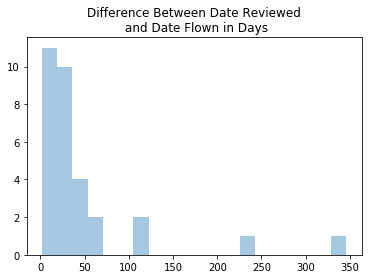

In [13]:
sns.distplot(time_difference, kde = False)
plt.title("Difference Between Date Reviewed\n and Date Flown in Days")

In [14]:
np.quantile(time_difference, 0.8)

50.0

It seems that 80% of reviews are posted within 50 days, and since we are missing most of the `date_flown` columns, I'll assume that the date flown is close to the date reviewed.

#### Data Cleaning

Some data cleaning is now necessary.  Here is the plan:

- Isolate the reviewer country
- *Split `route` into origin and destination* (not crucial due to large amount of NaNs)

##### Isolate the reviewer country

Each entry has something along the lines of

```
\n\nRalf-Peter Weber (Gibraltar) 31st August 2015
```

With the country consistently in brackets.  We can use regex to isolate the country name.

Source:
https://stackoverflow.com/questions/54077038/use-regular-expression-to-extract-elements-from-a-pandas-data-frame

In [15]:
# pattern matches any characters between brackets
pattern = "\((.*)\)"
# extract items that match the pattern in reviewer_countries
countries = reviews["reviewer_country"].str.findall(pattern).str[0]

# replace reviewer country with extracted countries
reviews["reviewer_country"] = countries

Since `route` has ~80% of it's data missing, in interest of time I won't parse the column into origin and destination.  If there were more data I would split the string on the word "to".

In [16]:
reviews.to_csv(save_path, index = False)